In [1]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES']='1'

from fastai import *
from fastai.vision import *
from superRes.generators import *
from superRes.critics import *
from superRes.dataset import *
from superRes.loss import *
from superRes.save import *
from superRes.fid_loss import *
from superRes.ssim import *
from superRes.metrics import *
from pathlib import Path
import torch.nn.functional as F

import torchvision
import geffnet # efficient/ mobile net

In [2]:
def get_DIV2k_data_QF(pLow, bs:int, sz:int):
    """Given the path of low resolution images
       returns a databunch
    """
    src = ImageImageList.from_folder(pLow).split_by_idxs(train_idx=list(range(0,800)), valid_idx=list(range(800,900)))
    
    data = (src.label_from_func(lambda x: path_fullRes/(x.name.replace(".jpg", ".png"))).transform(
            get_transforms(
                max_rotate=30,
                max_lighting=.4,
                max_warp=.4
            ),
            size=sz,
            tfm_y=True,
        ).databunch(bs=bs, num_workers=8, no_check=True).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [3]:
def do_fit(learn, epochs,save_name, lrs=slice(1e-3), pct_start=0.9):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=7)

In [4]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'
path_lowRes_128 = path/'DIV2K_train_LR_128'
path_lowRes_256 = path/'DIV2K_train_LR_256'

proj_id = 'unet_superRes_mobilenetV3_SSIM'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

nf_factor = 2
pct_start = 1e-8

In [5]:
print(path_fullRes)

dataset/DIV2K_train_HR


In [6]:
model = geffnet.mobilenetv3_small_minimal_100

In [7]:
loss_func = F.mse_loss

# 128px

In [8]:
bs=10
sz=256
lr = 1e-2
wd = 1e-3
epochs = 1

In [9]:
data_gen = get_DIV2k_data_QF(path_lowRes_128, bs=bs, sz=sz)

In [10]:
x, y = data_gen.one_batch()

# LPIPS

In [11]:
mod = lpips.PerceptualLoss(model='net-lin', net='alex', use_gpu=True, gpu_ids=[0])
d = mod.forward(x,y);

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [12]:
d.size()

torch.Size([10, 1, 1, 1])

In [13]:
d.mean()

tensor(0.3301, device='cuda:0', grad_fn=<MeanBackward0>)

# Brisque

In [14]:
from brisque import BRISQUE

In [15]:
brisque = BRISQUE()

In [16]:
x[0].shape

torch.Size([3, 256, 256])

In [17]:
x[0].permute(1, 2, 0).numpy().shape

(256, 256, 3)

In [18]:
brisque.get_score(x[0].permute(1, 2, 0).numpy())

113.3821487815103

In [19]:
values = []
for img in x:
    score = brisque.get_score(img.permute(1,2,0).numpy())
    values.append(score)

In [20]:
len(values)

10

# NIQE

In [21]:
%load_ext autoreload

In [22]:
%autoreload 2

In [23]:
from skvideo.measure.niqe import *
from torchvision import transforms

In [24]:
x[0][0].shape

torch.Size([256, 256])

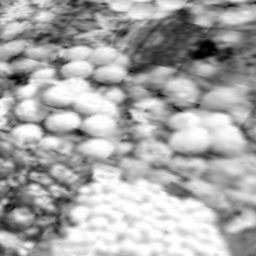

In [25]:
transforms.ToPILImage()(x[0][0]).convert("RGB")

In [26]:
values = []
for img in x:
    score = niqe(img[0].numpy())
    values.append(score)
values

[array([26.6615], dtype=float32),
 array([24.657578], dtype=float32),
 array([26.654642], dtype=float32),
 array([25.927893], dtype=float32),
 array([26.962053], dtype=float32),
 array([25.63817], dtype=float32),
 array([26.0426], dtype=float32),
 array([26.07195], dtype=float32),
 array([26.602365], dtype=float32),
 array([26.7043], dtype=float32)]

In [27]:
niqe(x[0][0].numpy())

array([26.6615], dtype=float32)

In [28]:
bs=40
sz=32
lr = 1e-2
wd = 1e-3
epochs = 1

In [29]:
data_gen = get_DIV2k_data_QF(path_lowRes_128, bs=bs, sz=sz)

In [30]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=nf_factor)

In [31]:
class BRISQUE_Metric_std(Callback):
    def __init__(self):
        super().__init__()
        self.name = "std_brisque"
        self.brisque = BRISQUE()

    def on_epoch_begin(self, **kwargs):
        self.values = []

    def on_batch_begin(self, last_input, last_target, **kwargs):
        for img in last_input:
            score = self.brisque.get_score(img.permute(1, 2, 0).cpu().numpy())
            self.values.append(score)
        
        for img in last_target:
            score = self.brisque.get_score(img.permute(1, 2, 0).cpu().numpy())
            self.values.append(score)

    def on_epoch_end(self, last_metrics, **kwargs):
        metrics = [sum(self.input_values) / len(self.input_values),
                   sum(self.target_values) / len(self.target_values)]
        return add_metrics(last_metrics, [metrics])

In [32]:
data_gen = get_DIV2k_data_QF(path_lowRes_128, bs=10, sz=256)

In [33]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=nf_factor)

In [34]:
learn_gen.metrics.append(LPIPS_Metric_gen())
learn_gen.metrics.append(LPIPS_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_gen())
learn_gen.metrics.append(BRISQUE_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_target())
learn_gen.metrics.append(NIQE_Metric_gen())
learn_gen.metrics.append(NIQE_Metric_input())
learn_gen.metrics.append(NIQE_Metric_target())

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done
Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [35]:
learn_gen.metrics

[LPIPS_Metric_gen,
 LPIPS_Metric_input,
 BRISQUE_Metric_gen,
 BRISQUE_Metric_input,
 BRISQUE_Metric_target,
 NIQE_Metric_gen,
 NIQE_Metric_input,
 NIQE_Metric_target]

In [36]:
learn_gen.fit_one_cycle(1, lr, pct_start=.9)

epoch,train_loss,valid_loss,gen_lpips,in_lpips,brisque gen,in,tar,niqe gen,in,tar,time
0,0.360985,0.160866,0.472838,0.408446,77.331652,96.264983,79.548818,19.697727,22.641680,19.608082,01:47
